In [1]:
%matplotlib notebook

import IPython
import itertools
import keras
import numpy as np
import os
import matplotlib.pyplot as plt

from collections import Counter

from keras import backend as K
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.utils import plot_model

from matplotlib import rcParams
from matplotlib.image import imread
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Hiragino Maru Gothic Pro', 
                               'Yu Gothic', 
                               'Meirio', 
                               'Takao', 
                               'IPAexGothic', 
                               'IPAPGothic', 
                               'VL PGothic', 
                               'Noto Sans CJK JP']

from sklearn.metrics import confusion_matrix

import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='3'

Using TensorFlow backend.


----

In [2]:
(x_train, y_train), (_x_validate, _y_validate) = mnist.load_data()

----

<IPython.core.display.Javascript object>


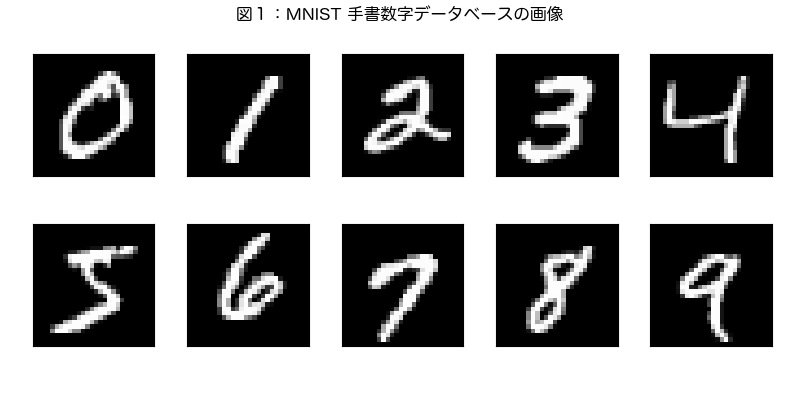

In [3]:
_, ((ax0, ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8, ax9)) = plt.subplots(2, 5, figsize=(8,4))

for i,ax in enumerate([ax0, ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9]):
    idx = np.where(y_train[0:20]==i)[0][0]
    ax.imshow(x_train[idx], cmap='gray')
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())

plt.subplots_adjust(top=0.91)
plt.tight_layout(pad=2.0)
#plt.subplots_tool()
plt.suptitle('図１：MNIST 手書数字データベースの画像')
plt.show()

plt.savefig('図１.png', dpi=300)

<IPython.core.display.Javascript object>


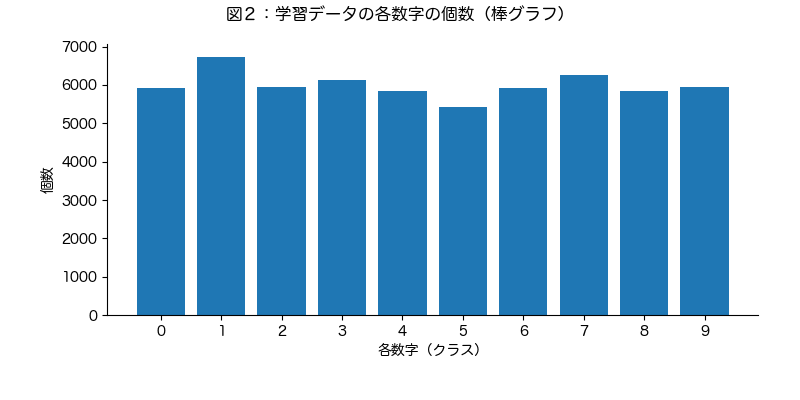

In [4]:
digit_counts = Counter(y_train)

_, ax = plt.subplots(1, 1, figsize=(8,4))
ax.bar(digit_counts.keys(), digit_counts.values())
ax.set_xticks(range(0,10))
ax.set_xlabel('各数字（クラス）')
ax.set_ylabel('個数')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.subplots_adjust(top=0.91)
plt.suptitle('図２：学習データの各数字の個数（棒グラフ）')
plt.tight_layout(pad=3.0)
plt.show()

plt.savefig('図２.png', dpi=300)

----

In [5]:
BATCH_SIZE = 128
NUM_CLASSES = 10

In [6]:
# 乱数ジェネレーターをシード
np.random.seed(1234)

num_test_samples_per_class = 20

# validate データをさらに validate / test に分ける
_test_ids = []
for c in [0,1,2,3,4,5,6,7,8,9]:
    _idx = np.random.choice(np.where(_y_validate==c)[0], 
                           size=(num_test_samples_per_class,),
                           replace=False)
    _test_ids.extend(_idx)

# create index masks for validation- and test-sets
_test = np.zeros(_x_validate.shape[0], dtype=bool)
_test[_test_ids] = True
_validate = ~_test

x_validate = _x_validate[_validate, :, :]
y_validate = _y_validate[_validate]

x_test = _x_validate[_test, :, :]
y_test = _y_validate[_test]

# reshape for a flattened input layer 28 x 28 pixels -> 784
x_train = x_train.reshape(x_train.shape[0], 784)
x_validate = x_validate.reshape(x_validate.shape[0], 784)
x_test = x_test.reshape(x_test.shape[0], 784)

# transfrom from 8-bit int value to float in range [0.0, 1.0]
x_train = x_train.astype('float32')
x_validate = x_validate.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_validate /= 255
x_test /= 255
print('Data for Multilayer Perceptron experiment:')
print('  x_train shape: {}'.format(x_train.shape))
print('  x_validate shape: {}'.format(x_validate.shape))
print('  x_test shape: {}'.format(x_test.shape))
print('  {} training samples'.format(x_train.shape[0]))
print('  {} validation samples'.format(x_validate.shape[0]))
print('  {} test samples'.format(x_test.shape[0]))

Data for Multilayer Perceptron experiment:
  x_train shape: (60000, 784)
  x_validate shape: (9800, 784)
  x_test shape: (200, 784)
  60000 training samples
  9800 validation samples
  200 test samples


In [7]:
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, NUM_CLASSES)
y_validate = keras.utils.to_categorical(y_validate, NUM_CLASSES)
y_test = keras.utils.to_categorical(y_test, NUM_CLASSES)

In [8]:
models = []

#### モデル１: 2 16-node layers Multilayer Perceptron, 10 epochs

* Simple, 2-layer Perceptron.
* Input layer is the 28 x 28 pixel grayscale image flattened to a 784-element vector.
* Hidden layers are both 16-neurons each, for no particular reason.

c.f. [3BLUE1BROWN Series S3, E1; But what is a Neural Network? | Deep Learning, chapter 1](https://www.youtube.com/watch?reload=9&v=aircAruvnKk)

In [9]:
perceptron1 = Sequential()

perceptron1.add(Dense(16, input_shape=(784,), activation='relu'))
perceptron1.add(Dense(16, activation='relu'))
perceptron1.add(Dense(16, activation='relu'))
perceptron1.add(Dense(10, activation='softmax'))

perceptron1.compile(loss=keras.losses.categorical_crossentropy,
                    optimizer=keras.optimizers.Adadelta(),
                    metrics=['accuracy'])

print(perceptron1.summary())

models.append(perceptron1)

plot_model(perceptron1, 'model1_2L_perceptron_10-epochs.png', show_shapes=True)

W0831 02:18:44.013972 140735751172992 deprecation_wrapper.py:119] From /Users/brooke/anaconda3/envs/nextgen/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0831 02:18:44.029139 140735751172992 deprecation_wrapper.py:119] From /Users/brooke/anaconda3/envs/nextgen/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0831 02:18:44.032021 140735751172992 deprecation_wrapper.py:119] From /Users/brooke/anaconda3/envs/nextgen/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0831 02:18:44.085922 140735751172992 deprecation_wrapper.py:119] From /Users/brooke/anaconda3/envs/nextgen/lib/python3.6/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Pl

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 16)                12560     
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_3 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_4 (Dense)              (None, 10)                170       
Total params: 13,274
Trainable params: 13,274
Non-trainable params: 0
_________________________________________________________________
None


#### モデル２: clone of モデル１ 2 16-node layers Multilayer Perceptron, but trained over 20 epochs

In [10]:
perceptron2 = keras.models.clone_model(perceptron1)

perceptron2.compile(loss=keras.losses.categorical_crossentropy,
                    optimizer=keras.optimizers.Adadelta(),
                    metrics=['accuracy'])

print(perceptron2.summary())

models.append(perceptron2)

plot_model(perceptron2, 'model2_2L_perceptron_20-epochs.png', show_shapes=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 16)                12560     
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_3 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_4 (Dense)              (None, 10)                170       
Total params: 13,274
Trainable params: 13,274
Non-trainable params: 0
_________________________________________________________________
None


#### モデル３: clone of モデル１ 2 16-node layers Multilayer Perceptron, but trained over 50 epochs

In [11]:
perceptron3 = keras.models.clone_model(perceptron1)

perceptron3.compile(loss=keras.losses.categorical_crossentropy,
                    optimizer=keras.optimizers.Adadelta(),
                    metrics=['accuracy'])

print(perceptron3.summary())

models.append(perceptron3)

plot_model(perceptron3, 'model3_2L_perceptron_50-epochs.png', show_shapes=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 16)                12560     
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_3 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_4 (Dense)              (None, 10)                170       
Total params: 13,274
Trainable params: 13,274
Non-trainable params: 0
_________________________________________________________________
None


#### モデル４: 4 16-node layer Multilayer Perceptron, 10 epochs

In [12]:
perceptron4 = Sequential()

perceptron4.add(Dense(16, input_shape=(784,), activation='relu'))
perceptron4.add(Dense(16, activation='relu'))
perceptron4.add(Dense(16, activation='relu'))
perceptron4.add(Dense(16, activation='relu'))
perceptron4.add(Dense(16, activation='relu'))
perceptron4.add(Dense(10, activation='softmax'))

perceptron4.compile(loss=keras.losses.categorical_crossentropy,
                    optimizer=keras.optimizers.Adadelta(),
                    metrics=['accuracy'])

print(perceptron4.summary())

models.append(perceptron4)

plot_model(perceptron4, 'model4_4L_perceptron_10-epochs.png', show_shapes=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 16)                12560     
_________________________________________________________________
dense_6 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_7 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_8 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_9 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_10 (Dense)             (None, 10)                170       
Total params: 13,818
Trainable params: 13,818
Non-trainable params: 0
_________________________________________________________________
None


#### モデル５: clone of モデル４ 4 16-node layer Multilayer Perceptron, but trained over 20 epochs

In [13]:
perceptron5 = keras.models.clone_model(perceptron4)

perceptron5.compile(loss=keras.losses.categorical_crossentropy,
                    optimizer=keras.optimizers.Adadelta(),
                    metrics=['accuracy'])

print(perceptron5.summary())

models.append(perceptron5)

plot_model(perceptron5, 'model5_4L_perceptron_20-epochs.png', show_shapes=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 16)                12560     
_________________________________________________________________
dense_6 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_7 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_8 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_9 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_10 (Dense)             (None, 10)                170       
Total params: 13,818
Trainable params: 13,818
Non-trainable params: 0
_________________________________________________________________
None


#### モデル６: clone of モデル４ 4 16-node layer Multilayer Perceptron, but trained over 50 epochs

In [14]:
perceptron6 = keras.models.clone_model(perceptron4)

perceptron6.compile(loss=keras.losses.categorical_crossentropy,
                    optimizer=keras.optimizers.Adadelta(),
                    metrics=['accuracy'])

print(perceptron6.summary())

models.append(perceptron6)

plot_model(perceptron6, 'model6_4L_perceptron_50-epochs.png', show_shapes=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 16)                12560     
_________________________________________________________________
dense_6 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_7 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_8 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_9 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_10 (Dense)             (None, 10)                170       
Total params: 13,818
Trainable params: 13,818
Non-trainable params: 0
_________________________________________________________________
None


#### モデル７: 4-layer (32, 64, 128, 256) Multilayer Perceptron, 10 epochs

In [15]:
perceptron7 = Sequential()

perceptron7.add(Dense(32, input_shape=(784,), activation='relu'))
perceptron7.add(Dense(32, activation='relu'))
perceptron7.add(Dense(64, activation='relu'))
perceptron7.add(Dense(128, activation='relu'))
perceptron7.add(Dense(256, activation='relu'))
perceptron7.add(Dense(10, activation='softmax'))

perceptron7.compile(loss=keras.losses.categorical_crossentropy,
                    optimizer=keras.optimizers.Adadelta(),
                    metrics=['accuracy'])

print(perceptron7.summary())

models.append(perceptron7)

plot_model(perceptron7, 'model7_4Lmixed_perceptron_10-epochs.png', show_shapes=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 32)                25120     
_________________________________________________________________
dense_12 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_13 (Dense)             (None, 64)                2112      
_________________________________________________________________
dense_14 (Dense)             (None, 128)               8320      
_________________________________________________________________
dense_15 (Dense)             (None, 256)               33024     
_________________________________________________________________
dense_16 (Dense)             (None, 10)                2570      
Total params: 72,202
Trainable params: 72,202
Non-trainable params: 0
_________________________________________________________________
None


#### モデル８: clone of モデル７ 4-layer (32, 64, 128, 256) Multilayer Perceptron, but trained over 20 epochs

In [16]:
perceptron8 = keras.models.clone_model(perceptron7)

perceptron8.compile(loss=keras.losses.categorical_crossentropy,
                    optimizer=keras.optimizers.Adadelta(),
                    metrics=['accuracy'])

print(perceptron8.summary())

models.append(perceptron8)

plot_model(perceptron8, 'model8_4Lmixed_perceptron_20-epochs.png', show_shapes=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 32)                25120     
_________________________________________________________________
dense_12 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_13 (Dense)             (None, 64)                2112      
_________________________________________________________________
dense_14 (Dense)             (None, 128)               8320      
_________________________________________________________________
dense_15 (Dense)             (None, 256)               33024     
_________________________________________________________________
dense_16 (Dense)             (None, 10)                2570      
Total params: 72,202
Trainable params: 72,202
Non-trainable params: 0
_________________________________________________________________
None


#### モデル９: clone of モデル７ 4-layer (32, 64, 128, 256) Multilayer Perceptron, but trained over 50 epochs

In [17]:
perceptron9 = keras.models.clone_model(perceptron7)

perceptron9.compile(loss=keras.losses.categorical_crossentropy,
                    optimizer=keras.optimizers.Adadelta(),
                    metrics=['accuracy'])

print(perceptron9.summary())

models.append(perceptron9)

plot_model(perceptron9, 'model9_4Lmixed_perceptron_20-epochs.png', show_shapes=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 32)                25120     
_________________________________________________________________
dense_12 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_13 (Dense)             (None, 64)                2112      
_________________________________________________________________
dense_14 (Dense)             (None, 128)               8320      
_________________________________________________________________
dense_15 (Dense)             (None, 256)               33024     
_________________________________________________________________
dense_16 (Dense)             (None, 10)                2570      
Total params: 72,202
Trainable params: 72,202
Non-trainable params: 0
_________________________________________________________________
None


<IPython.core.display.Javascript object>


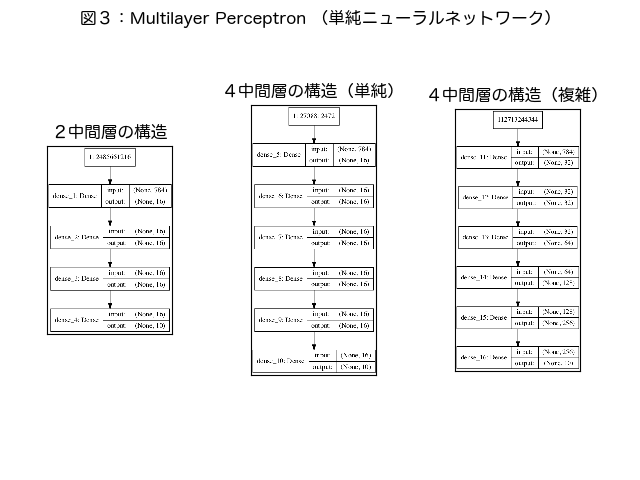

In [18]:
_, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=False)

# models 1, 2 & 3 (2-layers)
ax1.imshow(imread('model1_2L_perceptron_10-epochs.png'))
ax1.xaxis.set_major_locator(plt.NullLocator())
ax1.yaxis.set_major_locator(plt.NullLocator())
ax1.set_title('２中間層の構造')

# models 4, 5 & 6 (4-layers)
ax2.imshow(imread('model4_4L_perceptron_10-epochs.png'))
ax2.xaxis.set_major_locator(plt.NullLocator())
ax2.yaxis.set_major_locator(plt.NullLocator())
ax2.set_title('４中間層の構造（単純）')

# models 7, 8 & 9: (4-layers, mixed)
ax3.imshow(imread('model7_4Lmixed_perceptron_10-epochs.png'))
ax3.xaxis.set_major_locator(plt.NullLocator())
ax3.yaxis.set_major_locator(plt.NullLocator())
ax3.set_title('４中間層の構造（複雑）')

plt.subplots_adjust(top=0.91)
plt.suptitle('図３：Multilayer Perceptron （単純ニューラルネットワーク）')
plt.tight_layout(pad=3)
plt.show()

plt.savefig('図３.png', dpi=300)

----

In [19]:
print('Training Multilayer Perceptron models...')

np.random.seed(1234)

# models 1, 4 and 7 will be trained across 10 epochs
# models 2, 5 and 8 will be trained across 20 epochs
# models 3, 6 and 9 will be trained across 50 epochs
epochs = [10, 20, 50, 10, 20, 50, 10, 20, 50]

histories = []
for i,(model, num_epochs) in enumerate(zip(models, epochs)):
    print('モデル{}: 学習を開始する・・・'.format(i+1))
    history = model.fit(x_train, y_train,
                        batch_size=BATCH_SIZE,
                        epochs=num_epochs,
                        shuffle=True,
                        verbose=1,
                        validation_data=(x_validate, y_validate))
    histories.append(history)
    score = model.evaluate(x_validate, y_validate, verbose=0)
    print('validation loss: {:.5F}, validation accuracy: {:.5F}'.format(*score))
    print('------------------')

W0831 02:18:52.824666 140735751172992 deprecation.py:323] From /Users/brooke/anaconda3/envs/nextgen/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0831 02:18:52.911942 140735751172992 deprecation_wrapper.py:119] From /Users/brooke/anaconda3/envs/nextgen/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Training Multilayer Perceptron models...
モデル1: 学習を開始する・・・
Train on 60000 samples, validate on 9800 samples
Epoch 1/10
60000/60000 [==============================] - 1s 22us/step - loss: 0.5608 - acc: 0.8265 - val_loss: 0.2724 - val_acc: 0.9201
Epoch 2/10
60000/60000 [==============================] - 1s 11us/step - loss: 0.2545 - acc: 0.9253 - val_loss: 0.2219 - val_acc: 0.9360
Epoch 3/10
60000/60000 [==============================] - 1s 11us/step - loss: 0.2146 - acc: 0.9380 - val_loss: 0.2029 - val_acc: 0.9421
Epoch 4/10
60000/60000 [==============================] - 1s 11us/step - loss: 0.1941 - acc: 0.9430 - val_loss: 0.1950 - val_acc: 0.9449
Epoch 5/10
60000/60000 [==============================] - 1s 12us/step - loss: 0.1794 - acc: 0.9478 - val_loss: 0.1823 - val_acc: 0.9473
Epoch 6/10
60000/60000 [==============================] - 1s 14us/step - loss: 0.1685 - acc: 0.9504 - val_loss: 0.1906 - val_acc: 0.9444
Epoch 7/10
60000/60000 [==============================] - 1s 13us/step 

Epoch 28/50
60000/60000 [==============================] - 1s 11us/step - loss: 0.0926 - acc: 0.9728 - val_loss: 0.1487 - val_acc: 0.9591
Epoch 29/50
60000/60000 [==============================] - 1s 11us/step - loss: 0.0912 - acc: 0.9728 - val_loss: 0.1454 - val_acc: 0.9606
Epoch 30/50
60000/60000 [==============================] - 1s 11us/step - loss: 0.0898 - acc: 0.9737 - val_loss: 0.1433 - val_acc: 0.9616
Epoch 31/50
60000/60000 [==============================] - 1s 11us/step - loss: 0.0891 - acc: 0.9735 - val_loss: 0.1424 - val_acc: 0.9614
Epoch 32/50
60000/60000 [==============================] - 1s 11us/step - loss: 0.0878 - acc: 0.9740 - val_loss: 0.1462 - val_acc: 0.9618
Epoch 33/50
60000/60000 [==============================] - 1s 11us/step - loss: 0.0872 - acc: 0.9745 - val_loss: 0.1427 - val_acc: 0.9621
Epoch 34/50
60000/60000 [==============================] - 1s 11us/step - loss: 0.0856 - acc: 0.9746 - val_loss: 0.1442 - val_acc: 0.9610
Epoch 35/50
60000/60000 [=========

60000/60000 [==============================] - 1s 12us/step - loss: 0.1985 - acc: 0.9421 - val_loss: 0.2021 - val_acc: 0.9426
Epoch 5/50
60000/60000 [==============================] - 1s 12us/step - loss: 0.1812 - acc: 0.9465 - val_loss: 0.1949 - val_acc: 0.9428
Epoch 6/50
60000/60000 [==============================] - 1s 12us/step - loss: 0.1697 - acc: 0.9499 - val_loss: 0.1813 - val_acc: 0.9448
Epoch 7/50
60000/60000 [==============================] - 1s 12us/step - loss: 0.1609 - acc: 0.9525 - val_loss: 0.1808 - val_acc: 0.9456
Epoch 8/50
60000/60000 [==============================] - 1s 12us/step - loss: 0.1526 - acc: 0.9544 - val_loss: 0.1685 - val_acc: 0.9509
Epoch 9/50
60000/60000 [==============================] - 1s 12us/step - loss: 0.1457 - acc: 0.9566 - val_loss: 0.1684 - val_acc: 0.9495
Epoch 10/50
60000/60000 [==============================] - 1s 12us/step - loss: 0.1401 - acc: 0.9583 - val_loss: 0.1669 - val_acc: 0.9509
Epoch 11/50
60000/60000 [==========================

60000/60000 [==============================] - 2s 32us/step - loss: 0.4895 - acc: 0.8395 - val_loss: 0.2094 - val_acc: 0.9372
Epoch 2/20
60000/60000 [==============================] - 1s 20us/step - loss: 0.1838 - acc: 0.9436 - val_loss: 0.1570 - val_acc: 0.9519
Epoch 3/20
60000/60000 [==============================] - 1s 20us/step - loss: 0.1421 - acc: 0.9564 - val_loss: 0.1406 - val_acc: 0.9562
Epoch 4/20
60000/60000 [==============================] - 1s 20us/step - loss: 0.1192 - acc: 0.9638 - val_loss: 0.1292 - val_acc: 0.9598
Epoch 5/20
60000/60000 [==============================] - 1s 20us/step - loss: 0.1034 - acc: 0.9676 - val_loss: 0.1225 - val_acc: 0.9637
Epoch 6/20
60000/60000 [==============================] - 1s 20us/step - loss: 0.0927 - acc: 0.9713 - val_loss: 0.1225 - val_acc: 0.9630
Epoch 7/20
60000/60000 [==============================] - 1s 21us/step - loss: 0.0830 - acc: 0.9746 - val_loss: 0.1161 - val_acc: 0.9637
Epoch 8/20
60000/60000 [============================

60000/60000 [==============================] - 1s 21us/step - loss: 0.0084 - acc: 0.9973 - val_loss: 0.1948 - val_acc: 0.9708
Epoch 40/50
60000/60000 [==============================] - 1s 20us/step - loss: 0.0064 - acc: 0.9979 - val_loss: 0.1860 - val_acc: 0.9718
Epoch 41/50
60000/60000 [==============================] - 1s 21us/step - loss: 0.0065 - acc: 0.9978 - val_loss: 0.2045 - val_acc: 0.9712
Epoch 42/50
60000/60000 [==============================] - 1s 21us/step - loss: 0.0057 - acc: 0.9980 - val_loss: 0.1984 - val_acc: 0.9721
Epoch 43/50
60000/60000 [==============================] - 1s 21us/step - loss: 0.0051 - acc: 0.9985 - val_loss: 0.2100 - val_acc: 0.9709
Epoch 44/50
60000/60000 [==============================] - 1s 21us/step - loss: 0.0048 - acc: 0.9985 - val_loss: 0.2069 - val_acc: 0.9697
Epoch 45/50
60000/60000 [==============================] - 1s 21us/step - loss: 0.0043 - acc: 0.9986 - val_loss: 0.2057 - val_acc: 0.9728
Epoch 46/50
60000/60000 [=====================

#### Save the models (architecture & weights)

In [20]:
perceptron1.save('model1_2L_perceptron_10-epochs.h5')
perceptron2.save('model2_2L_perceptron_20-epochs.h5')
perceptron3.save('model3_2L_perceptron_50-epochs.h5')
perceptron4.save('model4_4L_perceptron_10-epochs.h5')
perceptron5.save('model5_4L_perceptron_20-epochs.h5')
perceptron6.save('model6_4L_perceptron_50-epochs.h5')
perceptron7.save('model7_4Lmixed_perceptron_10-epochs.h5')
perceptron8.save('model8_4Lmixed_perceptron_20-epochs.h5')
perceptron9.save('model9_4Lmixed_perceptron_20-epochs.h5')

In [21]:
# tick-formatter sets tick label for
# indices 1 and all others divisble by 3
def _tickformatter(v, tn):
    if int(v+1)==1 or int(v+1)%10==0:
        return int(v+1)

#### Plot training/validation loss rates

<IPython.core.display.Javascript object>


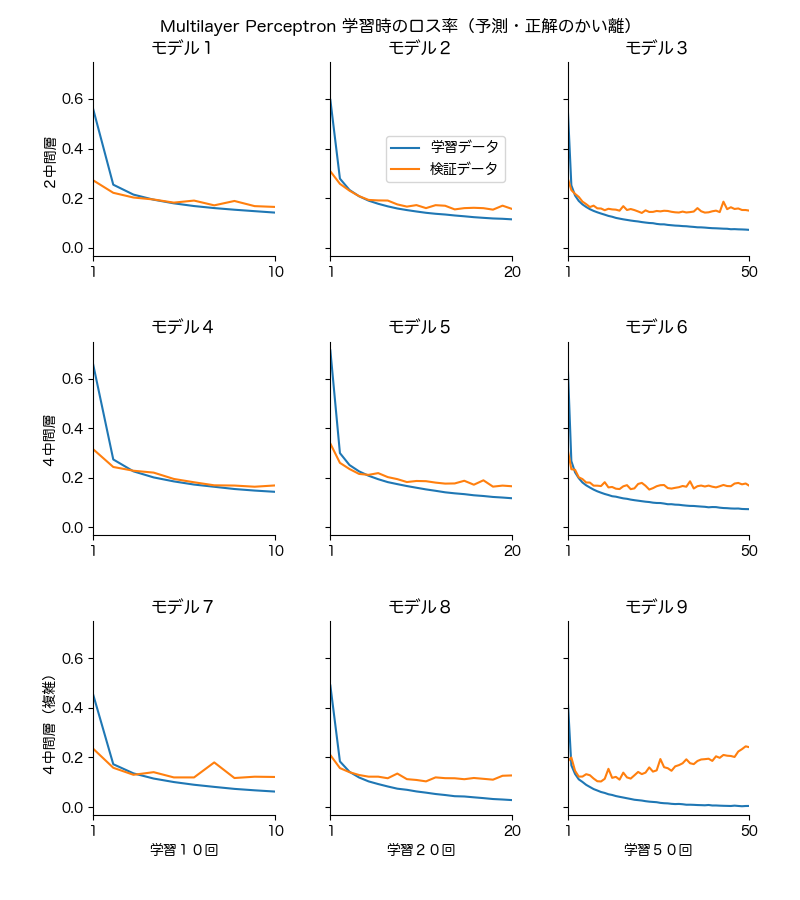

In [116]:
_, ((ax1,ax2,ax3), (ax4,ax5,ax6), (ax7,ax8,ax9)) = plt.subplots(3, 3,
                                                                sharey=True, 
                                                                figsize=(8,9))

# models 1, 2 and 3
ax1.plot(histories[0].history['loss'], label='学習データ')
ax1.plot(histories[0].history['val_loss'], label='検証データ')
ax1.set_title('モデル１')
ax1.set_xlim(0,9)
ax1.set_xticks([0,9])
ax1.xaxis.set_major_formatter(plt.FuncFormatter(_tickformatter))
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.set_ylabel('２中間層')

ax2.plot(histories[1].history['loss'], label='学習データ')
ax2.plot(histories[1].history['val_loss'], label='検証データ')
ax2.set_title('モデル２')
ax2.set_xlim(0,19)
ax2.set_xticks([0,19])
ax2.xaxis.set_major_formatter(plt.FuncFormatter(_tickformatter))
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.legend(loc='center right')

ax3.plot(histories[2].history['loss'], label='学習データ')
ax3.plot(histories[2].history['val_loss'], label='検証データ')
ax3.set_title('モデル３')
ax3.set_xlim(0,49)
ax3.set_xticks([0,49])
ax3.xaxis.set_major_formatter(plt.FuncFormatter(_tickformatter))
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)

# models 4, 5 and 6
ax4.plot(histories[3].history['loss'], label='学習データ')
ax4.plot(histories[3].history['val_loss'], label='検証データ')
ax4.set_title('モデル４')
ax4.set_xlim(0,9)
ax4.set_xticks([0,9])
ax4.xaxis.set_major_formatter(plt.FuncFormatter(_tickformatter))
ax4.spines['top'].set_visible(False)
ax4.spines['right'].set_visible(False)
ax4.set_ylabel('４中間層')

ax5.plot(histories[4].history['loss'], label='学習データ')
ax5.plot(histories[4].history['val_loss'], label='検証データ')
ax5.set_title('モデル５')
ax5.set_xlim(0,19)
ax5.set_xticks([0,19])
ax5.xaxis.set_major_formatter(plt.FuncFormatter(_tickformatter))
ax5.spines['top'].set_visible(False)
ax5.spines['right'].set_visible(False)

ax6.plot(histories[5].history['loss'], label='学習データ')
ax6.plot(histories[5].history['val_loss'], label='検証データ')
ax6.set_title('モデル６')
ax6.set_xlim(0,49)
ax6.set_xticks([0,49])
ax6.xaxis.set_major_formatter(plt.FuncFormatter(_tickformatter))
ax6.spines['top'].set_visible(False)
ax6.spines['right'].set_visible(False)

# models 7, 8 and 9
ax7.plot(histories[6].history['loss'], label='学習データ')
ax7.plot(histories[6].history['val_loss'], label='検証データ')
ax7.set_title('モデル７')
ax7.set_xlim(0,9)
ax7.set_xticks([0,9])
ax7.xaxis.set_major_formatter(plt.FuncFormatter(_tickformatter))
ax7.spines['top'].set_visible(False)
ax7.spines['right'].set_visible(False)
ax7.set_xlabel('学習１０回')
ax7.set_ylabel('４中間層（複雑）')

ax8.plot(histories[7].history['loss'], label='学習データ')
ax8.plot(histories[7].history['val_loss'], label='検証データ')
ax8.set_title('モデル８')
ax8.set_xlim(0,19)
ax8.set_xticks([0,19])
ax8.xaxis.set_major_formatter(plt.FuncFormatter(_tickformatter))
ax8.spines['top'].set_visible(False)
ax8.spines['right'].set_visible(False)
ax8.set_xlabel('学習２０回')

ax9.plot(histories[8].history['loss'], label='学習データ')
ax9.plot(histories[8].history['val_loss'], label='検証データ')
ax9.set_title('モデル９')
ax9.set_xlim(0,49)
ax9.set_xticks([0,49])
ax9.xaxis.set_major_formatter(plt.FuncFormatter(_tickformatter))
ax9.spines['top'].set_visible(False)
ax9.spines['right'].set_visible(False)
ax9.set_xlabel('学習５０回')

plt.subplots_adjust(top=0.91)
plt.suptitle('Multilayer Perceptron 学習時のロス率（予測・正解のかい離）')
#plt.figtext(0.5, 0.03, '学習回数', fontsize=10, ha='center')
#plt.figtext(0.04, 0.5, 'ロス率', fontsize=10, ha='center', rotation=90)
plt.tight_layout(pad=3)
plt.show()

plt.savefig('図４.png', dpi=300)

#### Plot training/validation accurracy rates

<IPython.core.display.Javascript object>


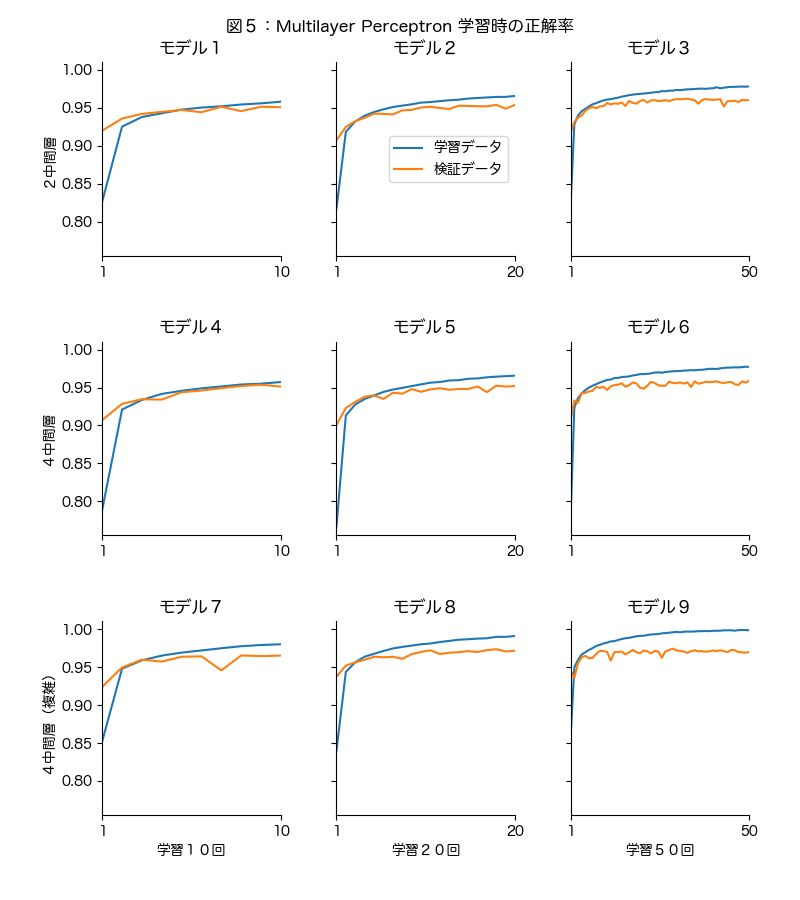

In [23]:
_, ((ax1,ax2,ax3), (ax4,ax5,ax6), (ax7,ax8,ax9)) = plt.subplots(3, 3,
                                                                sharey=True, 
                                                                figsize=(8,9))

# models 1, 2 and 3
ax1.plot(histories[0].history['acc'], label='学習データ')
ax1.plot(histories[0].history['val_acc'], label='検証データ')
ax1.set_title('モデル１')
ax1.set_xlim(0,9)
ax1.set_xticks([0,9])
ax1.xaxis.set_major_formatter(plt.FuncFormatter(_tickformatter))
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.set_ylabel('２中間層')

ax2.plot(histories[1].history['acc'], label='学習データ')
ax2.plot(histories[1].history['val_acc'], label='検証データ')
ax2.set_title('モデル２')
ax2.set_xlim(0,19)
ax2.set_xticks([0,19])
ax2.xaxis.set_major_formatter(plt.FuncFormatter(_tickformatter))
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.legend(loc='center right')

ax3.plot(histories[2].history['acc'], label='学習データ')
ax3.plot(histories[2].history['val_acc'], label='検証データ')
ax3.set_title('モデル３')
ax3.set_xlim(0,49)
ax3.set_xticks([0,49])
ax3.xaxis.set_major_formatter(plt.FuncFormatter(_tickformatter))
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)

# models 4, 5 and 6
ax4.plot(histories[3].history['acc'], label='学習データ')
ax4.plot(histories[3].history['val_acc'], label='検証データ')
ax4.set_title('モデル４')
ax4.set_xlim(0,9)
ax4.set_xticks([0,9])
ax4.xaxis.set_major_formatter(plt.FuncFormatter(_tickformatter))
ax4.spines['top'].set_visible(False)
ax4.spines['right'].set_visible(False)
ax4.set_ylabel('４中間層')

ax5.plot(histories[4].history['acc'], label='学習データ')
ax5.plot(histories[4].history['val_acc'], label='検証データ')
ax5.set_title('モデル５')
ax5.set_xlim(0,19)
ax5.set_xticks([0,19])
ax5.xaxis.set_major_formatter(plt.FuncFormatter(_tickformatter))
ax5.spines['top'].set_visible(False)
ax5.spines['right'].set_visible(False)

ax6.plot(histories[5].history['acc'], label='学習データ')
ax6.plot(histories[5].history['val_acc'], label='検証データ')
ax6.set_title('モデル６')
ax6.set_xlim(0,49)
ax6.set_xticks([0,49])
ax6.xaxis.set_major_formatter(plt.FuncFormatter(_tickformatter))
ax6.spines['top'].set_visible(False)
ax6.spines['right'].set_visible(False)

# models 7, 8 and 9
ax7.plot(histories[6].history['acc'], label='学習データ')
ax7.plot(histories[6].history['val_acc'], label='検証データ')
ax7.set_title('モデル７')
ax7.set_xlim(0,9)
ax7.set_xticks([0,9])
ax7.xaxis.set_major_formatter(plt.FuncFormatter(_tickformatter))
ax7.spines['top'].set_visible(False)
ax7.spines['right'].set_visible(False)
ax7.set_xlabel('学習１０回')
ax7.set_ylabel('４中間層（複雑）')

ax8.plot(histories[7].history['acc'], label='学習データ')
ax8.plot(histories[7].history['val_acc'], label='検証データ')
ax8.set_title('モデル８')
ax8.set_xlim(0,19)
ax8.set_xticks([0,19])
ax8.xaxis.set_major_formatter(plt.FuncFormatter(_tickformatter))
ax8.spines['top'].set_visible(False)
ax8.spines['right'].set_visible(False)
ax8.set_xlabel('学習２０回')

ax9.plot(histories[8].history['acc'], label='学習データ')
ax9.plot(histories[8].history['val_acc'], label='検証データ')
ax9.set_title('モデル９')
ax9.set_xlim(0,49)
ax9.set_xticks([0,49])
ax9.xaxis.set_major_formatter(plt.FuncFormatter(_tickformatter))
ax9.spines['top'].set_visible(False)
ax9.spines['right'].set_visible(False)
ax9.set_xlabel('学習５０回')

plt.subplots_adjust(top=0.91)
plt.suptitle('図５：Multilayer Perceptron 学習時の正解率')
#plt.figtext(0.5, 0.03, '学習回数', fontsize=10, ha='center')
#plt.figtext(0.04, 0.5, 'ロス率', fontsize=10, ha='center', rotation=90)
plt.tight_layout(pad=3)
plt.show()

plt.savefig('図５.png', dpi=300)

----

## Test

Use the test data to make predictions for all 9 models, creating a confusion matrix.

<IPython.core.display.Javascript object>


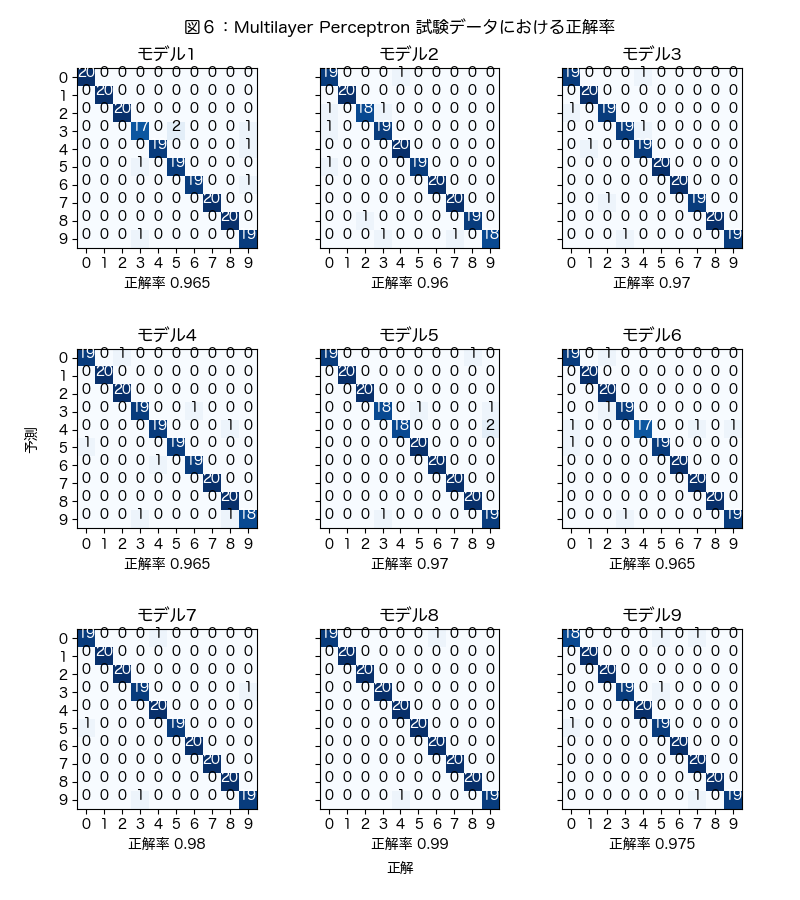

In [24]:
classes = range(10)

_, ((ax1,ax2,ax3), (ax4,ax5,ax6), (ax7,ax8,ax9)) = plt.subplots(3, 3,
                                                                sharey=True, 
                                                                figsize=(8,9))

for idx, (model,ax) in enumerate(zip(models, (ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9))):
    predicted = np.argmax(model.predict(x_test), axis=1)
    actual = np.argmax(y_test, axis=1)
    confusion_mtx = confusion_matrix(actual, predicted)
    
    test_acc = np.sum(predicted==actual) / len(actual)
    #print('model {} accuracy: {}'.format(idx+1, test_acc))
    
    ax.imshow(confusion_mtx, interpolation='nearest', cmap=plt.cm.Blues)
    ax.set_title('モデル{}'.format(idx+1))
    #ax1.colorbar()
    ax.set_xticks(classes)
    ax.set_yticks(classes)
    ax.set_xlabel('正解率 {}'.format(test_acc))

    thresh = confusion_mtx.max() / 2.
    for i, j in itertools.product(range(confusion_mtx.shape[0]), range(confusion_mtx.shape[1])):
        ax.text(j, i, confusion_mtx[i, j],
                 horizontalalignment="center",
                 color="white" if confusion_mtx[i, j] > thresh else "black")

plt.subplots_adjust(top=0.91)
plt.suptitle('図６：Multilayer Perceptron 試験データにおける正解率')
plt.figtext(0.5, 0.03, '正解', fontsize=10, ha='center')
plt.figtext(0.04, 0.5, '予測', fontsize=10, ha='center', rotation=90)
plt.tight_layout(pad=4.2)
plt.show()

plt.savefig('図６.png', dpi=300)

----

#### Output the results from training period (training + validation)

In [97]:
import pandas as pd

acc = []
for m,ne in zip(range(10),(10,20,50,10,20,50,10,20,50)):
    for t in range(ne):
        d = {'model': 'model{}'.format(m+1)}
        d['epoch'] = int(t+1)
        d['loss'] = histories[m].history['loss'][t]
        d['acc'] = histories[m].history['acc'][t]
        d['val_loss'] = histories[m].history['val_loss'][t]
        d['val_acc'] = histories[m].history['val_acc'][t]
        acc.append(d)
training_hist = pd.DataFrame(acc)
training_hist.to_csv('training_history.csv', index=False)

In [98]:
training_results = training_hist.groupby('model').mean()
training_results = training_results.filter(['model', 'loss', 'acc', 'val_loss', 'val_acc'])
training_results.to_csv('training_results.csv', index=False)
training_results

,loss,acc,val_loss,val_acc
model,,,,
model1,0.217615,0.935208,0.195858,0.943480
model2,0.178766,0.946904,0.185693,0.944495
model3,0.117923,0.965100,0.159889,0.955696
model4,0.232995,0.929742,0.205853,0.940020
model5,0.195491,0.942187,0.200964,0.941765
model6,0.122345,0.962643,0.174098,0.951859
model7,0.135304,0.957710,0.144380,0.955918
model8,0.091623,0.970991,0.125825,0.965041
model9,0.041142,0.987129,0.163384,0.968082


#### Output the results from testing

In [99]:
acc = []
for i,m in enumerate(models):
    predicted = np.argmax(m.predict(x_test), axis=1)
    actual = np.argmax(y_test, axis=1)
    for p,a in zip(predicted, actual):
        d = {'model': 'model{}'.format(i+1)}
        d['predicted'] = p
        d['actual'] = a
        d['is_correct'] = p==a
        acc.append(d)
test_hist = pd.DataFrame(acc)
test_hist.to_csv('test_history.csv', index=False)

In [100]:
test_results = test_hist.groupby('model').sum()
test_results = test_results.filter(['is_correct'])
test_results['acc'] = test_results['is_correct'] / len(y_test)
test_results.columns = ['num_correct', 'acc']
test_results.num_correct = test_results.num_correct.astype(int)
test_results.to_csv('test_results.csv', index=False)
test_results

,num_correct,acc
model,,
model1,193,0.965
model2,192,0.960
model3,194,0.970
model4,193,0.965
model5,194,0.970
model6,193,0.965
model7,196,0.980
model8,198,0.990
model9,195,0.975


#### Averaged test results by training epoch count

In [111]:
test_results['epoch_count'] = [10,20,50,10,20,50,10,20,50]
test_epoch_count_acc = test_results.groupby('epoch_count').mean().filter(['acc'])
test_epoch_count_acc.to_csv('test_results_avg_by_epoch.csv')
test_epoch_count_acc

,acc
epoch_count,
10,0.970000
20,0.973333
50,0.970000


#### Averaged test results by model architecture

In [114]:
test_results['arch'] = ['2','2','2','4','4','4','4+','4+','4+']
test_arch_acc = test_results.groupby('arch').mean().filter(['acc'])
test_arch_acc.to_csv('test_results_avg_by_arch.csv')
test_arch_acc

,acc
arch,
2,0.965000
4,0.966667
4+,0.981667


----

### Compare the errors in the worst and best models

#### モデル２：２中間層・学習回数、２０回

<IPython.core.display.Javascript object>


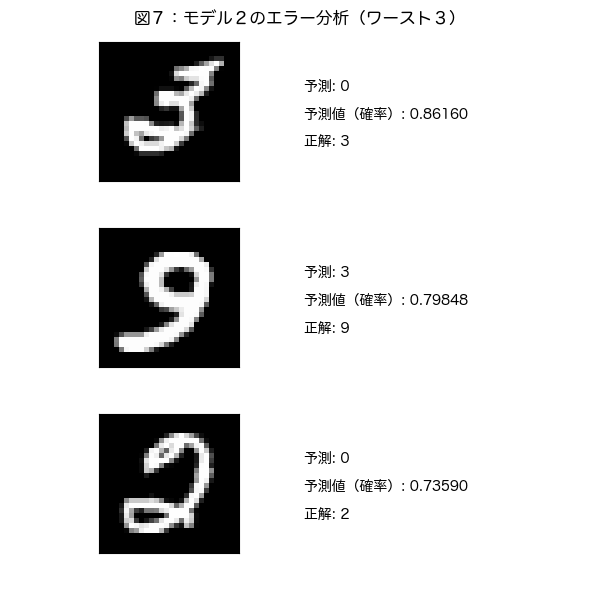

In [28]:
model = perceptron2

predictions = model.predict(x_test)
predicted = np.argmax(model.predict(x_test), axis=1)
actual = np.argmax(y_test, axis=1)

error_idx = np.argwhere(predicted!=actual).flatten()

pred_values = np.max(model.predict(x_test)[error_idx], axis=1)
top3_errors = error_idx[pred_values.argsort()[-3:][::-1]]
_desc = np.argwhere((np.max(model.predict(x_test)[top3_errors], axis=1))).flatten()
top3_errors = top3_errors[_desc]

_, col_axes = plt.subplots(3, 2, figsize=(6,6))

for i,col_ax in zip(top3_errors, col_axes):
    axA, axB = col_ax
    axA.imshow(x_test[i].reshape((28,28)), cmap='gray')
    axA.xaxis.set_major_locator(plt.NullLocator())
    axA.yaxis.set_major_locator(plt.NullLocator())
    
    axB.text(0.001, 0.65, '予測: {}'.format(predicted[i]))
    axB.text(0.001, 0.45, '予測値（確率）: {:.5f}'.format(np.max(predictions[i])))
    axB.text(0.001, 0.25, '正解: {}'.format(actual[i]))
    axB.set_xticks([])
    axB.set_yticks([])
    axB.spines['top'].set_visible(False)
    axB.spines['right'].set_visible(False)
    axB.spines['bottom'].set_visible(False)
    axB.spines['left'].set_visible(False)

plt.subplots_adjust(top=0.91)
plt.tight_layout(pad=3.0)
plt.suptitle('図７：モデル２のエラー分析（ワースト３）')
plt.show()

plt.savefig('図７.png', dpi=300)

#### モデル３：２中間層・学習回数、５０回

<IPython.core.display.Javascript object>


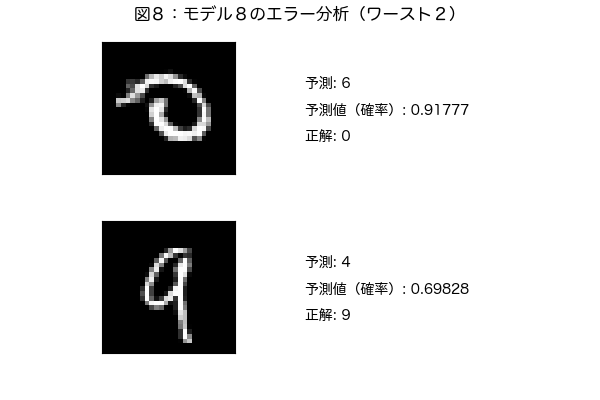

In [36]:
model = perceptron8

predictions = model.predict(x_test)
predicted = np.argmax(model.predict(x_test), axis=1)
actual = np.argmax(y_test, axis=1)

error_idx = np.argwhere(predicted!=actual).flatten()

pred_values = np.max(model.predict(x_test)[error_idx], axis=1)
top2_errors = error_idx[pred_values.argsort()[-2:][::-1]]
_desc = np.argwhere((np.max(model.predict(x_test)[top2_errors], axis=1))).flatten()
top2_errors = top2_errors[_desc]

_, col_axes = plt.subplots(2, 2, figsize=(6,4))

for i,col_ax in zip(top2_errors, col_axes):
    axA, axB = col_ax
    axA.imshow(x_test[i].reshape((28,28)), cmap='gray')
    axA.xaxis.set_major_locator(plt.NullLocator())
    axA.yaxis.set_major_locator(plt.NullLocator())
    
    axB.text(0.001, 0.65, '予測: {}'.format(predicted[i]))
    axB.text(0.001, 0.45, '予測値（確率）: {:.5f}'.format(np.max(predictions[i])))
    axB.text(0.001, 0.25, '正解: {}'.format(actual[i]))
    axB.set_xticks([])
    axB.set_yticks([])
    axB.spines['top'].set_visible(False)
    axB.spines['right'].set_visible(False)
    axB.spines['bottom'].set_visible(False)
    axB.spines['left'].set_visible(False)

plt.subplots_adjust(top=0.91)
plt.tight_layout(pad=3.0)
plt.suptitle('図８：モデル８のエラー分析（ワースト２）')
plt.show()

plt.savefig('図８.png', dpi=300)